# Data Collection and Analysis for Training Data

### This document is for working with the data we pull from training the different mdoels.

Import libraries

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
import scipy as stats
import pandas as pd

Load data from file

In [5]:
def load_data(file_path, model=None):
    # file_path = 'DQL_PLOT/TEST_PLOTS/plot_file_vector.pkl'
    # file_path = 'DQL_PLOT/TEST_PLOTS/plot_file_grid.pkl'

    with open(file_path, 'rb') as file:
        data = pickle.load(file)
        data = np.array(data)
    
        
    # load data as dataframe
    if model == 'tql': data = {'scores': data[0]/10, 'apple': data[1],'steps': np.cumsum(data[1]) , 'time per apple': data[1] / (data[0]/10)}

    else: data = {'scores': data[0]/10,
            'steps_per_game': data[1],
            'epsilon': data[2],
            'game': np.arange(len(data[0])),
            'steps' : np.cumsum(data[1]),
            'time per apple': data[1] / (data[0]/10)
            }
    dataframe = pd.DataFrame(data = data)

    return dataframe 

# Defining data
onestep = load_data(file_path='DQL_PLOT/TEST_PLOTS/onestep_training_17_01.pkl')
vector = load_data(file_path='DQL_PLOT/TEST_PLOTS/vector_training_17_01.pkl')
tql = load_data(file_path='TAB_MODEL_AND_PLOT/DATA_PLOT_TRAINING/tab_optim_rewards.pkl', model="tql")
grid = load_data(file_path='DQL_PLOT/TEST_PLOTS/grid_training_18_01.pkl')
rand = load_data(file_path='DQL_PLOT/DATA_PLOTS/30mil_random_non_training_pt4_18_01.pkl', model="tql")



C:\Users\vietn\AppData\Local\Temp\ipykernel_5752\1727309082.py:18: RuntimeWarning: divide by zero encountered in divide
  'time per apple': data[1] / (data[0]/10)
C:\Users\vietn\AppData\Local\Temp\ipykernel_5752\1727309082.py:11: RuntimeWarning: divide by zero encountered in divide
  if model == 'tql': data = {'scores': data[0]/10, 'apple': data[1],'steps': np.cumsum(data[1]) , 'time per apple': data[1] / (data[0]/10)}


Export CSV

In [225]:
# Export as csv from pickle
def export_csv(dataframe=None, save_path=None):
    return dataframe.to_csv(save_path, index=False)

# input variables
dataframe = tql
save_path='TAB_MODEL_AND_PLOT/DATA_PLOT_RUNNING/tab_optim_rewards_running.csv'

# Export to csv
export_csv(dataframe, save_path)


Plot score data

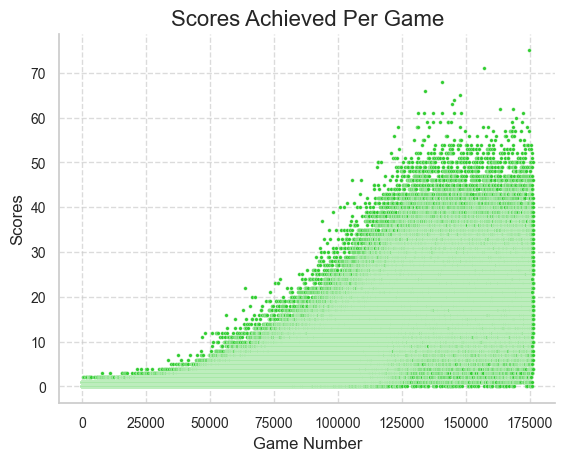

In [6]:
""" plt.scatter(games, scores)
plt.title('Scores Achieved Per Game')
plt.xlabel('Game Number')
plt.ylabel('Scores')
plt.grid(True)
plt.show() """



sns.set(style="whitegrid")
sns.scatterplot(x=onestep['game'], y=onestep['scores'], s=7, color="limegreen")
plt.title('Scores Achieved Per Game', fontsize=16)
plt.xlabel('Game Number')
plt.ylabel('Scores')
# plt.gca().invert_xaxis() # Invert axis
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.grid(True, linestyle='--', alpha=0.7)

sns.despine()
plt.show()

## Line plot

### Batch

In [7]:
def get_batch(dataframe, mode='max', batch_size=100, ep=True):


    # Definere arrays 
    score = np.array(dataframe['scores'])
    game = np.array(dataframe['steps'])
    if ep is True: epsilon = np.array(dataframe['epsilon'])

    # Udregner antal batches
    num_batches = len(score) // batch_size

    # Lav batches
    batched_games = np.array(np.split(score[0: num_batches*batch_size], num_batches))

    # Udregner mean eller max for hver batch
    if mode == 'mean':
        batched_rest_mean = np.array(np.mean(score[num_batches*batch_size:]))
        batched_mean = np.mean(batched_games, axis=1)

    if mode == 'max':
        batched_rest_mean = np.array(np.max(score[num_batches*batch_size:]))
        batched_mean = np.max(batched_games, axis=1)

    # Samler batches i en dataframe
    batched_score = np.concatenate((batched_mean, [batched_rest_mean]))
    batched_game = game[::batch_size]
    if ep is True: batched_epsilon = epsilon[::batch_size]

    # Opsætning af data til dataframe
    if ep is True: data = {'score' : batched_score,
            'steps' : batched_game,
            'epsilon': batched_epsilon
            }
    else:

        data = {'score' : batched_score,
                'steps' : batched_game,
                }
        
    batched_df = pd.DataFrame(data = data)

    return batched_df

# Onestep batch
onestep_max = get_batch(onestep, mode='max', batch_size=500)

# Vector batch laves til samme længde som onestep
score_vec = np.array(vector['scores'])
convert_vec = len(score_vec)//len(onestep_max)

# vector batch
grid_max = get_batch(grid, mode='mean', batch_size=600)
vector_max = get_batch(vector, mode='max', batch_size=convert_vec)

# rand convertion
score_rand = np.array(rand['scores'])
convert_rand = len(score_rand)//len(grid_max)
# rand batch
rand_max = get_batch(rand, mode='mean', batch_size=1400, ep=False)


# Display begge batches
# display(onestep_max, vector_max, grid_max)
print(len(grid_max))
print(len(rand_max))




329
330


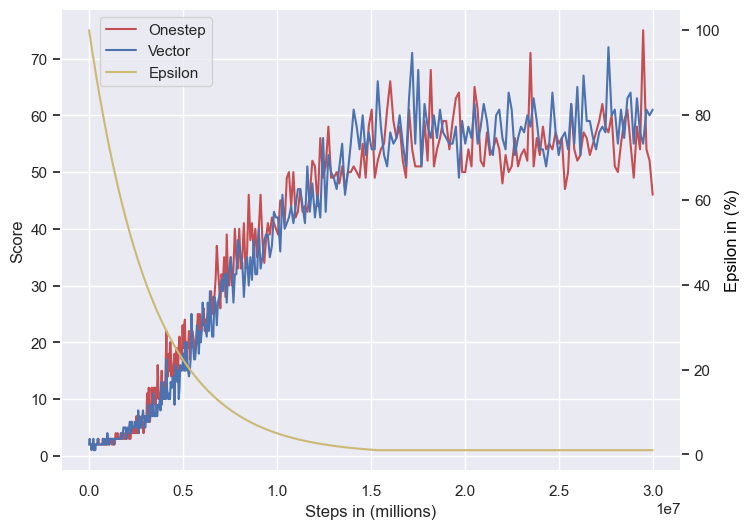

In [8]:
# Definere plot tema med seaborn
sns.set_theme(style="darkgrid")

# Ændre størrelse på plot
fig, ax1 = plt.subplots(figsize=(8, 6))

# Værdier og akser til plots
x = onestep_max['steps']
y1 = onestep_max['score']
y2 = vector_max['score'][:len(y1)]
y3 = onestep_max['epsilon'] * 100

# Skabelse af grafer og akser med seaborn
sns.lineplot(x=x, y=y1, color='r', label='Onestep', ax=ax1)
sns.lineplot(x=x, y=y2, color='b', label='Vector', ax=ax1)

# x og y akser labels
ax1.set_xlabel('Steps in (millions)')
ax1.set_ylabel('Score')

# Ny akse til epsilon
ax2 = ax1.twinx()
sns.lineplot(x=x, y=y3, color='y', ax=ax2)  

# Label for nye data
ax2.set_ylabel('Epsilon in (%)', color='black')

# Indsæt grid
ax1.set_axisbelow(True)
ax1.grid(True)

# Fjern grid for epsilon
ax2.grid(False)

# Indsættelse af legends
handles, labels = ax1.get_legend_handles_labels()
handle2, label2 = ax2.get_lines()[0], 'Epsilon'  
handles.append(handle2)
labels.append(label2)

# Indsættelse af legends for epsilon
ax1.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.05, 1))

plt.show()


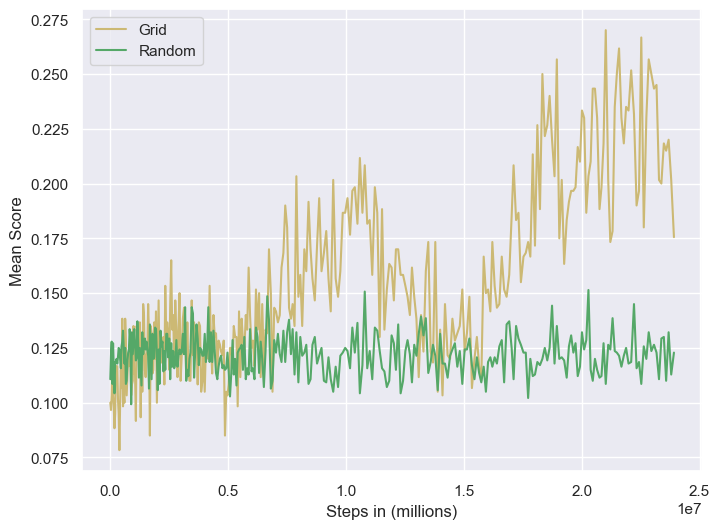

In [9]:
# Definere plot tema med seaborn
sns.set_theme(style="darkgrid")

# Ændre størrelse på plot
fig, ax1 = plt.subplots(figsize=(8, 6))

# Værdier og akser til plots
x = grid_max['steps']
y1 = grid_max['score']
y2 = rand_max['score'][:len(y1)]

# Skabelse af grafer og akser med seaborn
sns.lineplot(x=x, y=y1, color='y', label='Grid', ax=ax1)
sns.lineplot(x=x, y=y2, color='g', label='Random', ax=ax1)

# x og y akser labels
ax1.set_xlabel('Steps in (millions)')
ax1.set_ylabel('Mean Score')


# Indsæt grid
ax1.set_axisbelow(True)
ax1.grid(True)

# Indsættelse af legends
handles, labels = ax1.get_legend_handles_labels()
handles.append(handle2)
labels.append(label2)

# Indsættelse af legends for epsilon

plt.show()


Plot Running Mean Score

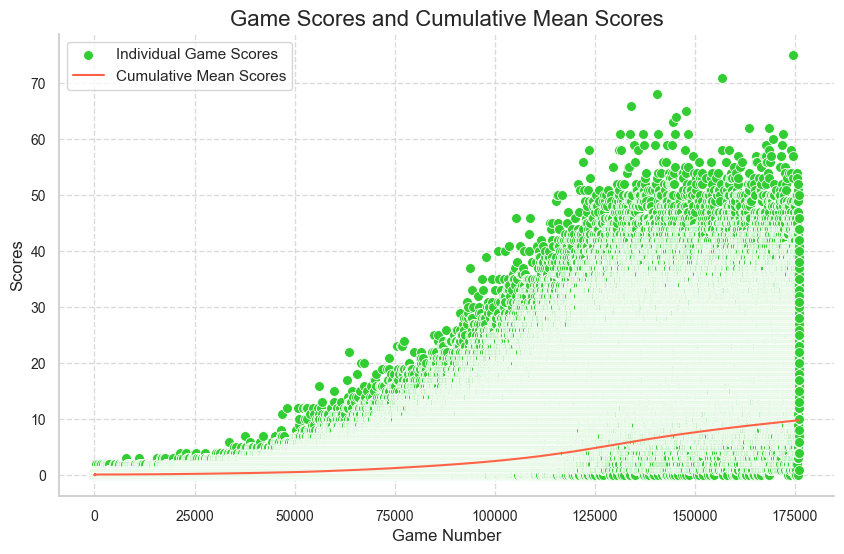

In [10]:
scores = onestep["scores"]
games = np.arange(1, len(scores) + 1)
cumulative_mean_scores = np.cumsum(scores) / games

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(x=games, y=scores, s=50, label='Individual Game Scores', color='limegreen')
sns.lineplot(x=games, y=cumulative_mean_scores, label='Cumulative Mean Scores', color='tomato')
plt.title('Game Scores and Cumulative Mean Scores', fontsize=16)
plt.xlabel('Game Number')
plt.ylabel('Scores')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
sns.despine()
plt.show()


Plot 95% Confidence Intervals

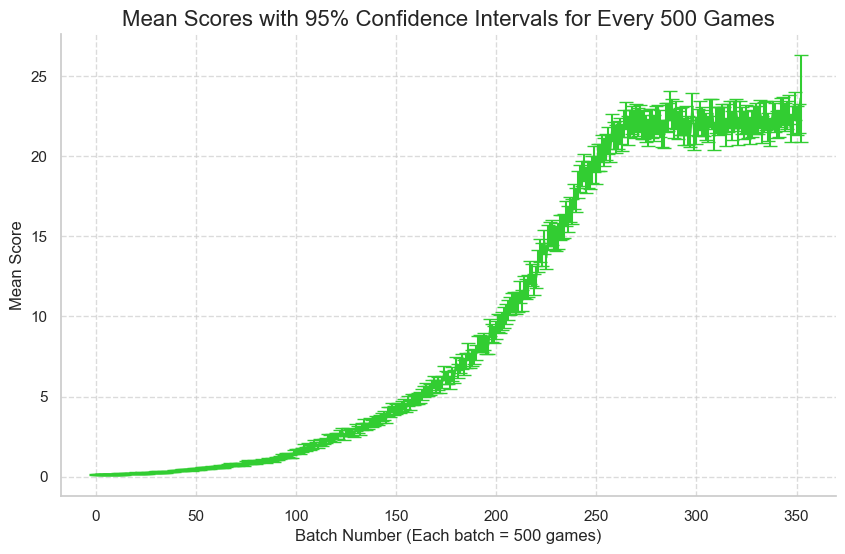

In [11]:
batch_size = 500 
batch = list(range(0, len(scores), batch_size))
mean_scores = []
confidence_intervals = []

# Mean and Confidence Intervals for each batch
for i in range(0, len(scores), batch_size):
    block = scores[i:i + batch_size]
    if len(block) == 0:
        continue

    mean = np.mean(block)
    std_dev = np.std(block)

    conf_ints = 1.96 * (std_dev / math.sqrt(len(block)))
    mean_scores.append(mean)
    confidence_intervals.append(conf_ints)

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(mean_scores)), mean_scores, yerr=confidence_intervals, capsize=5, label='Mean with 95% Confidence Intervals', color='limegreen')

plt.title('Mean Scores with 95% Confidence Intervals for Every 500 Games', fontsize=16)
plt.xlabel('Batch Number (Each batch = 500 games)')
plt.ylabel('Mean Score')

plt.grid(True, linestyle='--', alpha=0.7)

sns.despine()

plt.show()

## Status

In [12]:
# Status
model = ['grid']
dataframe = pd.DataFrame(columns=['model', 'high_scores','mean_last_100', 'games','epsilon', 'steps', 'progress'])

for name in model:
    file_path = f'DQL_PLOT/TEST_PLOTS/{name}_training_18_01.pkl'
    with open(file_path, 'rb') as file:
        data_load = pickle.load(file)
        data_load = np.array(data_load)

    new_row = {'model': [name],
            'high_scores': np.max(data_load[0]),
            'mean_last_100': np.mean(data_load[0][-10:]),
            'games': np.size(data_load[0]),
            'epsilon': [data_load[-1, -1]],
            'steps': np.sum(data_load[1]),
            'progress': f"{np.round((np.sum(data_load[1]) / 30_000_000)*100,2)}%"
            }
    
    new_row = pd.DataFrame(new_row)
    
    dataframe = pd.concat([dataframe, new_row], axis=0, ignore_index=True)

dataframe


C:\Users\vietn\AppData\Local\Temp\ipykernel_5752\1986934387.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataframe = pd.concat([dataframe, new_row], axis=0, ignore_index=True)


,model,high_scores,mean_last_100,games,epsilon,steps,progress
0,grid,50.0,2.0,197250,0.01,23988460.0,79.96%


## TQL results

In [13]:
df = pd.read_pickle('TQL\metric_files\metric_test_16_01.pkl')
print(df.columns)
df = df[['mean_score', 'step_punish', 'apple_reward', 'death_punish', 'closer_reward','mean_score_mid', 'mean_apple_mid']]

df.sort_values(by=['mean_score_mid'], inplace=True, ascending=False)

df['mean_score'] = df['mean_score'].apply(lambda x: [round(num, 2) for num in x])

df.head(10).reset_index(drop=True) 


Index(['index', 'mean_score', 'mean_time_apple', 'runs', 'file_path',
       'step_punish', 'apple_reward', 'death_punish', 'closer_reward',
       'mean_score_mid', 'mean_apple_mid'],
      dtype='object')


,mean_score,step_punish,apple_reward,death_punish,closer_reward,mean_score_mid,mean_apple_mid
0,"[159.13, 185.27]",3,132,-195,-1,172.200000,27.217284
1,"[155.57, 177.13]",-3,87,-268,2,166.350000,23.978316
2,"[141.84, 164.71]",-5,60,-120,5,153.275000,24.558149
3,"[140.53, 165.37]",1,69,-281,1,152.950000,31.572254
4,"[129.72, 154.53]",-2,147,-88,1,142.125000,26.414142
5,"[125.23, 149.65]",-1,83,-269,1,137.436364,25.765075
6,"[121.74, 145.5]",-3,127,-145,5,133.620833,24.761206
7,"[120.48, 145.41]",-1,113,-277,1,132.942857,26.522430
8,"[114.26, 142.85]",4,83,-262,2,128.551064,30.723409
9,"[113.83, 142.55]",5,70,-130,-3,128.188636,31.002132
